<a href="https://colab.research.google.com/github/PrabaKDataScience/DeepLearning/blob/main/NLP/02_medical_paper_abstract_shaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scope

> Make easy to read abstract of medical journal in PubMed 




## Harder to Read 

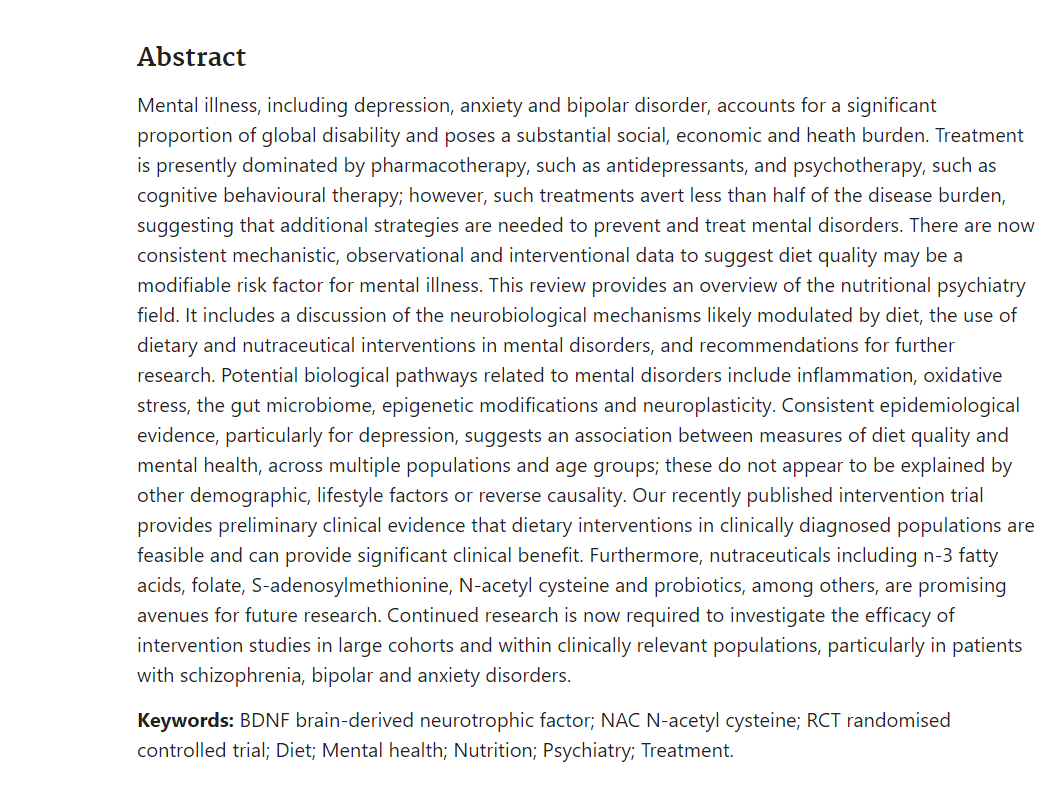

## Easier to Read

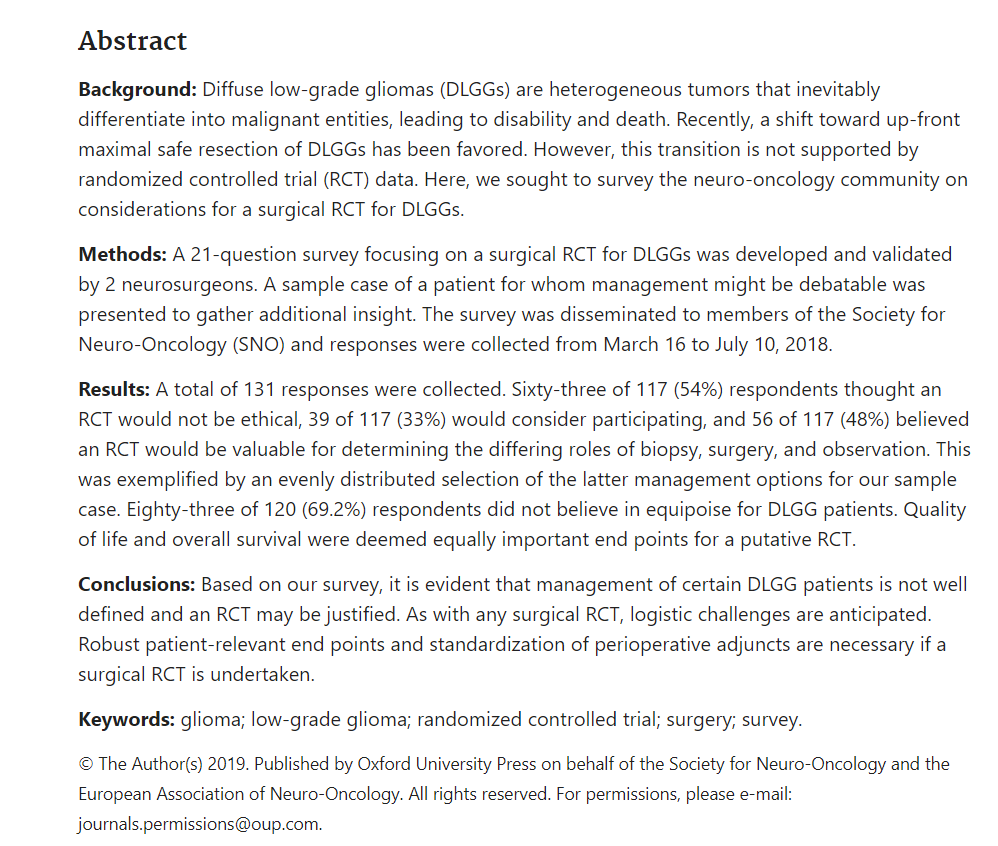

# Idea


> Make use of NLP Sequence model (many to one) classification to figure out each sentence classification.  




## Solution in a sentence

Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc)  to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

> 📖 **Resources:** Before going through the code in this notebook, you might want to get a background of what we're going to be doing. To do so, spend an hour (or two) going through the following papers and then return to this notebook:
1. Where our data is coming from: [*PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071)
2. Where our model is coming from: [*Neural networks for joint sentence
classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).


# Steps

* Downloading a text dataset ([PubMed RCT200k from GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct))
* Writing a preprocessing function to prepare our data for modelling
* Setting up a series of modelling experiments
  * Making a baseline (TF-IDF classifier)
  * Deep models with different combinations of: token embeddings, character embeddings, pretrained embeddings, positional embeddings
* Building our first multimodal model (taking multiple types of data inputs)
  * Replicating the model architecture from https://arxiv.org/pdf/1612.05251.pdf 
* Find the most wrong predictions
* Making predictions on PubMed abstracts from the wild

# Data Input

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


**Note**: The download folder contains four folders 


*   PubMed_200k_RCT --> Original data 
*   PubMed_200k_RCT_numbers_repalced_by_at --> Modified data
*   Pubmed_20k_RCt * --> 10% data

>   🤠  We focus on 10% data and then scale up to 100% data 



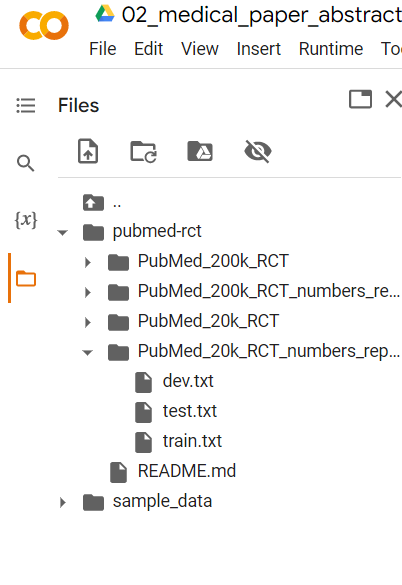

## Exploring the data 

In [3]:
import os
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
files = [data_dir+file for file in os.listdir(data_dir)]
files

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [4]:
def get_lines(filename):
  with open(filename,'r') as f:
    sentences = f.readlines()
    return sentences
    # for each in sentences[:20]:
    #   print(each)

#get_lines(files[0])

**Understanding** ✅ 


1.   Each sentence has the class on its begining
2.   Each medical journal has its abstract id on its strat with ###id



## Preprocess Data

In [5]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [6]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 445 ms, sys: 123 ms, total: 568 ms
Wall time: 569 ms


(180040, 30212, 30135)

In [7]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [8]:
train_df.head(5)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [9]:
train_df.shape

(180040, 4)

In [10]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

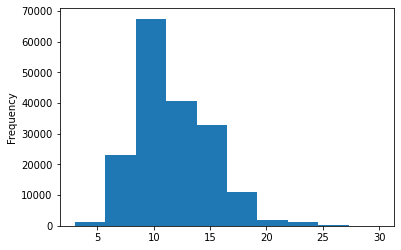

In [11]:
train_df.total_lines.plot.hist()

> Okay, looks like most of the abstracts are around 7 to 15 sentences in length.

In [12]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [13]:
# View first 15 lines of training sentences
train_sentences[:15]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Encoding

COnverting the target variable into numbers


1.   One hot encoding - Increases dimensions
2.   Label Encoding - No Increase


🤨 We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).


### Using sklearn to one hot encoding

In [14]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Using pandas for oneHot Encoding

In [15]:

with_dummies = pd.get_dummies(train_df["target"])

In [16]:
pd.concat([with_dummies, train_df.drop('target',axis=1)],axis=1)

,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,text,line_number,total_lines
0,0,0,0,1,0,to investigate the efficacy of @ weeks of dail...,0,11
1,0,0,1,0,0,a total of @ patients with primary knee oa wer...,1,11
2,0,0,1,0,0,outcome measures included pain reduction and i...,2,11
3,0,0,1,0,0,pain was assessed using the visual analog pain...,3,11
4,0,0,1,0,0,secondary outcome measures included the wester...,4,11
...,...,...,...,...,...,...,...,...
180035,0,0,0,0,1,for the absolute change in percent atheroma vo...,7,11
180036,0,0,0,0,1,"for pav , a significantly greater percentage o...",8,11
180037,0,0,0,0,1,both strategies had acceptable side effect pro...,9,11
180038,0,1,0,0,0,"compared with standard statin monotherapy , th...",10,11


In [17]:
with_dummies.to_numpy()

array([[0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)

### Label Encoding 

In [18]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# We have to know which class corresponds to which number

label_encoder.classes_


array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [78]:
num_classes =len(label_encoder.classes_)

In [20]:
set(train_labels_encoded)

{0, 1, 2, 3, 4}

> BACKGROUND : 0 
CONCLUSION : 1 ...

# Model

## Model 0 :  Baseline 

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),   # For Converting the text into numbers
    ("clf", MultinomialNB()) # For classification
])

model_0.fit(X=train_sentences, y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate 

model_0.score(X=val_sentences, y= val_labels_encoded)

0.7218323844829869

In [23]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
pd.DataFrame(val_sentences,baseline_preds)

,0
4,ige sensitization to aspergillus fumigatus and...
1,it is not clear whether these patients would b...
3,we sought to determine whether a @-month cours...
2,asthmatic patients who were ige sensitized to ...
2,primary outcomes were improvement in quality o...
...,...
4,pruritus occurred more frequently with the act...
4,three patients in the active-regimen group ( @...
4,hemoglobin values of grade @ ( @ to < @ g per ...
4,rates of response to a @-week interferon-free ...


In [25]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [26]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results


{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 1 : 

In [27]:
import tensorflow as tf
from tensorflow.keras import layers 

🎇 Since we'll be turning our sentences into numbers, it's a good idea to figure out how many words are in each sentence.

We have to pad the each sentences since NN model accepts only same size of input



In [28]:
import numpy as np
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

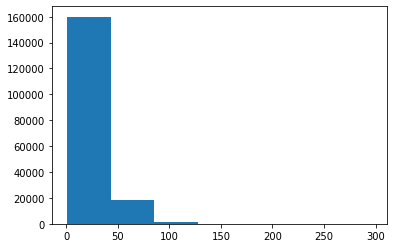

In [29]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);


In [30]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

Wonderful! It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).



### Vecorizer

In [31]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [32]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [33]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
worldwide , @ million adults undergo major noncardiac surgery annually , and @ million of these patients will have a major vascular complication .

Length of text: 24

Vectorized text:
[[2610 4193  266 1295  347 6370  115 5097    3 4193    4  111   12   95
    99    8  347  758 1101    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [35]:

# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:

# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

>> So far we converted the words in sentences to numbers . bUt we need to capture the relationship between those numbers using Embedding 



### Embedding 

In [37]:
token_embed = layers.Embedding(input_dim = max_tokens,
                               output_dim =128 , # Each word or token will be converted to a feature vector of size 128
                               mask_zero=True,
                               name="token_embedding")

In [38]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
print(f"Token sentence shape: {vectorized_sentence.shape} \n ")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
worldwide , @ million adults undergo major noncardiac surgery annually , and @ million of these patients will have a major vascular complication .

Sentence after vectorization (before embedding):
[[2610 4193  266 1295  347 6370  115 5097    3 4193    4  111   12   95
    99    8  347  758 1101    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Token sentence shape: (1, 55) 
 
Sentence after embedding:
[[[ 0.00722939  0.03508556  0.025959   ...  0.0318053  -0.03096518
   -0.00265629]
  [-0.00749553 -0.036384   -0.02812986 ...  0.03386202  0.01611975
   -0.01490211]
  [ 0.04211867  0.03413016 -0.03744427 ...  0.01414781  0.03632833
    0.01771555]
  ...
  [ 0.03329447  0.00709356 -0.00018216 ...  0.01378006 -0.01672767
   -0.0259938 ]
  [ 0.03329447  0.00709356 -0.00018216 ...  0.01378006 -0.01672767
   -0.0259938 ]
  [ 0.

### Data Prefetch 

In [39]:
# Our data train_sentences --> List contains string 
# train_labels_one_hot --> numpy array 
# We need a dataset 

train_data_slice = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_data_slice = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_data_slice = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

In [40]:
# Prefetch the input datset to speed up the datapipeline

# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_data_slice.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = val_data_slice.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_data_slice.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Conv 1D model

In [40]:
import tensorflow as tf 
from tensorflow.keras import layers 

inputs = layers.Input(shape=(1,),dtype='string')
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64, kernel_size =5,activation='relu',padding='same' )(x)
print(x.shape)
x = layers.GlobalMaxPooling1D()(x)
print(x.shape)
outputs = layers.Dense(units=num_classes,activation='softmax')(x)
model_1= tf.keras.models.Model(inputs,outputs)

(None, 55, 64)
(None, 64)


In [41]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

In [42]:
model_1.compile(loss = 'categorical_crossentropy',
             optimizer ='adam',
             metrics = ['accuracy'])

In [43]:
import numpy as np
train_s_array = np.array(train_sentences)
model_1_history = model_1.fit(train_dataset, 
            epochs=3, 
            steps_per_epoch = int(0.1*len(train_dataset)),
            validation_data = valid_dataset,
            validation_steps = int(0.1*len(valid_dataset))
    )


Epoch 1/3
562/562 [==============================] - 17s 14ms/step - loss: 0.8301 - accuracy: 0.6854 - val_loss: 0.5834 - val_accuracy: 0.7793
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.5764 - accuracy: 0.7907 - val_loss: 0.5428 - val_accuracy: 0.7965
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.5428 - accuracy: 0.8015 - val_loss: 0.5214 - val_accuracy: 0.8095


In [44]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 7s 8ms/step - loss: 0.5201 - accuracy: 0.8085


[0.5200966596603394, 0.8085197806358337]

In [45]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[6.8857384e-01, 5.8773372e-02, 5.0007366e-04, 2.4956027e-01,
        2.5923718e-03],
       [2.9436007e-01, 5.5097038e-01, 1.8014070e-03, 1.5003076e-01,
        2.8373727e-03],
       [2.0208837e-01, 4.6880767e-03, 1.6933075e-03, 7.9142207e-01,
        1.0821356e-04],
       ...,
       [2.0932336e-04, 1.9606277e-03, 2.1438936e-02, 1.3840036e-04,
        9.7625273e-01],
       [1.1377537e-02, 5.6790656e-01, 2.4472279e-02, 1.6073713e-02,
        3.8016987e-01],
       [2.9038411e-02, 9.6182925e-01, 2.5864725e-03, 4.0217154e-03,
        2.5242667e-03]], dtype=float32)

In [46]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [47]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [48]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.85197934595524,
 'precision': 0.8064262188615355,
 'recall': 0.8085197934595525,
 'f1': 0.8068396853550812}

In [49]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2 : Feature extraction with Pretrained model 



```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```

We'll keep the pretrained embeddings frozen (by setting `trainable=False`) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

In [50]:
# Using the Universal sentence Encoder from tensorflow hub 

# Downoad the USE 
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4')
tf_hub_embedding_layer.trainable=False




In [51]:
# Test out the embedding on a random sentence
import random
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
we performed a @-month , randomized , rater-blinded clinical trial involving @ adolescent patients with early-onset psychosis and either or both of their parents .

Sentence after embedding:
[-0.04158794  0.03505721 -0.0222596   0.03129382 -0.07603535  0.03792542
  0.05450201 -0.06507947 -0.01725697 -0.05169798  0.08880291 -0.02187795
  0.00802292  0.04278838  0.02264921 -0.01253126 -0.08960112 -0.03190589
 -0.06144214 -0.08705197  0.0733045   0.032242   -0.01957764 -0.0453549
 -0.01763021 -0.02033309 -0.01387833  0.05074344  0.00230553  0.01521568] (truncated output)...

Length of sentence embedding:
512


In [52]:
inputs = layers.Input(shape=[],dtype='string')
embededding = tf_hub_embedding_layer(inputs)
x =layers.Dense(128, activation='relu')(embededding)
outputs=layers.Dense(num_classes,activation='softmax')(x)
model_2 = tf.keras.models.Model(inputs,outputs)

#### Comparision of model1 with model 2 

In [53]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [54]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

##### When we compare the model 1 with model 2 , we understand that the pretrained model does the following for us


*   Tokenise
*   Embed
*   Global avergaing 

Thats why it gets a feature vector with elements 512 for each sentences after passing the pretrained layer . 

Whereas to obtain the same we did lot of steps in model_1. 


> Each sentence Tokenisation (55 elements) --> Each word embeddding--> (128 elements) --> Did convolution to choose features (reduced each token/word to 64 elems) --> Did avergae pooling (reduced each sentence to 64 elems) --> Dense layer for number of classes (reduced to 5 ) 



#### Compile and fit

In [55]:
model_2.compile(loss = 'categorical_crossentropy',
                optimizer ='adam',
                metrics = ['accuracy'])

In [56]:
# Fit feature extractor model for 3 epochs
model_2_hitory = model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 17ms/step - loss: 0.9177 - accuracy: 0.6497 - val_loss: 0.7955 - val_accuracy: 0.6918
Epoch 2/3
562/562 [==============================] - 11s 20ms/step - loss: 0.7660 - accuracy: 0.7042 - val_loss: 0.7523 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7478 - accuracy: 0.7141 - val_loss: 0.7329 - val_accuracy: 0.7164


In [57]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7361 - accuracy: 0.7159


[0.7361006736755371, 0.7158744931221008]

Since we aren't training our own custom embedding layer, training is much quicker.

Let's make some predictions and evaluate our feature extraction model.

In [58]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 11ms/step


array([[0.41189623, 0.38508618, 0.00298839, 0.19185144, 0.00817773],
       [0.39350253, 0.43092752, 0.00464926, 0.16766532, 0.00325548],
       [0.25721693, 0.1236752 , 0.0212615 , 0.56073356, 0.03711282],
       ...,
       [0.00228841, 0.00535455, 0.0581536 , 0.00107244, 0.93313104],
       [0.00388007, 0.04621296, 0.2160979 , 0.0016671 , 0.732142  ],
       [0.15445027, 0.3145925 , 0.45854297, 0.00599413, 0.06642013]],
      dtype=float32)

In [59]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [60]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.58744869588243,
 'precision': 0.7164521803190427,
 'recall': 0.7158744869588243,
 'f1': 0.7128975824036429}

In [61]:
baseline_results , model_1_results



({'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294},
 {'accuracy': 80.85197934595524,
  'precision': 0.8064262188615355,
  'recall': 0.8085197934595525,
  'f1': 0.8068396853550812})

🥇 Model 1 performs better till this point

## Model 3 : CNN 1D with character level embeddings 

### Tokenisation

> What we tried in Model 1 is CNN with word level tokenisation and embedding 

> What we rae going to do is Character level tokenisation and embedding

In [41]:
# We are going to split each sentence or sequence in the train sentences , val sentences to charecters 

def split_char(text):
  return " ".join(list(text))

split_char(random.choice(train_sentences))

't h e   p r i m a r y   e f f i c a c y   e n d p o i n t   o f   b o t h   s t u d i e s   w a s   t r o u g h   f o r c e d   e x p i r a t o r y   v o l u m e   i n   @   s   (   f e v @   )   o n   d a y   @   ,   w h i c h   w a s   a n a l y s e d   i n   t h e   i n t e n t i o n - t o - t r e a t   p o p u l a t i o n   .'

In [42]:
train_sentences_char = [split_char(i) for i in train_sentences]

In [43]:
train_sentences_char[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [44]:
val_sentences_char = [split_char(i) for i in val_sentences]
test_sentences_char = [split_char(i) for i in test_sentences]

In [45]:
# We have to find the lenght of each sequence which best captures the overall data
# We can fid the length of each sequence and choose the 95 percentile lenght, so that we cover the 95% of data 
# Those sequence which are above 95 percentile length will be truncated and below will be padded

train_sentences_len = [len(i) for i in train_sentences]


(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

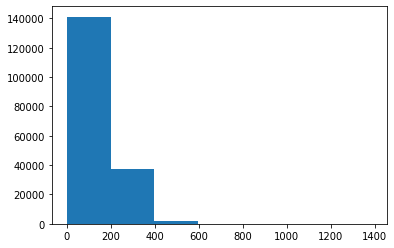

In [67]:
# Lets find the distribution 
from matplotlib import pyplot as plt
plt.hist(train_sentences_len,bins=7)

In [46]:
np.mean(train_sentences_len), np.percentile(train_sentences_len,95)

(149.3662574983337, 290.0)

In [47]:
percentile_95_length = int(np.percentile(train_sentences_len,95))

In [48]:
# We are going to limit 290 as the size of feature vector for each sequence 
# We have to find the vocabulary size 
# Since we are doing character level embedding the vocabulary size is going to be small 
# If you read random text from the training samples we see that it has only lowercase , symbols 

# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

All our characters going to be any one of the above characters. 

🎇 If you notice that it is missing with space

In [49]:
max_tokens = len(alphabet) +2 #( 1 for space and one for OOV out of vocabulary)


### Vectorizer


In [50]:
# Create a character tokeniser

char_vectoriser = TextVectorization(max_tokens =max_tokens,
                                    output_sequence_length = percentile_95_length,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [51]:
char_vectoriser.adapt(train_sentences_char)

In [52]:
rand_sen =  random.choice(train_sentences_char)
print('Random sentence : ', rand_sen)
char_vectoriser(rand_sen)

Random sentence :  a s s o c i a t i o n s   w e r e   e x a m i n e d   u s i n g   m u l t i v a r i a b l e   l i n e a r   r e g r e s s i o n   a n a l y s i s   .


<tf.Tensor: shape=(290,), dtype=int64, numpy=
array([ 5,  9,  9,  7, 11,  4,  5,  3,  4,  7,  6,  9, 20,  2,  8,  2,  2,
       24,  5, 15,  4,  6,  2, 10, 16,  9,  4,  6, 18, 15, 16, 12,  3,  4,
       21,  5,  8,  4,  5, 22, 12,  2, 12,  4,  6,  2,  5,  8,  8,  2, 18,
        8,  2,  9,  9,  4,  7,  6,  5,  6,  5, 12, 19,  9,  4,  9,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [53]:
# Check character vocabulary characteristics
char_vocab = char_vectoriser.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


### Embedding

In [54]:
from tensorflow.keras.layers import Embedding

char_embed  =  Embedding(input_dim = percentile_95_length , 
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

In [55]:

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{rand_sen}\n")
char_embed_example = char_embed(char_vectoriser([rand_sen]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
a s s o c i a t i o n s   w e r e   e x a m i n e d   u s i n g   m u l t i v a r i a b l e   l i n e a r   r e g r e s s i o n   a n a l y s i s   .

Embedded chars (after vectorization and embedding):
[[[ 0.00641052  0.02405128  0.03100819 ...  0.02237445  0.0414874
   -0.01375105]
  [ 0.04519467 -0.01633098 -0.00904883 ... -0.01338842  0.03110579
   -0.00422154]
  [ 0.04519467 -0.01633098 -0.00904883 ... -0.01338842  0.03110579
   -0.00422154]
  ...
  [-0.00068401  0.01516147 -0.01928375 ... -0.03444058  0.01061878
   -0.03409415]
  [-0.00068401  0.01516147 -0.01928375 ... -0.03444058  0.01061878
   -0.03409415]
  [-0.00068401  0.01516147 -0.01928375 ... -0.03444058  0.01061878
   -0.03409415]]]

Character embedding shape: (1, 290, 25)


In [78]:
# Model Building

inputs = layers.Input(shape=(1,),dtype='string')
char_vectorised = char_vectoriser(inputs)
char_embeded = char_embed(char_vectorised)
x = layers.Conv1D(filters=64, kernel_size =5,activation='relu',padding='same' )(char_embeded)
print(x.shape)
x = layers.GlobalMaxPooling1D()(x)
print(x.shape)
outputs = layers.Dense(units=num_classes,activation='softmax')(x)
model_3= tf.keras.models.Model(inputs,outputs)


(None, 290, 64)
(None, 64)


In [79]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           7250      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [80]:
model_3.compile(loss = 'categorical_crossentropy',
             optimizer ='adam',
             metrics = ['accuracy'])

In [81]:
# prepare the data
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences_char,train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences_char,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences_char, test_labels_one_hot))

In [82]:
train_dataset =  train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset =  val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset =  test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [83]:
len(train_dataset)

5627

In [84]:
model_3_history = model_3.fit(train_dataset, 
            epochs=3, 
            steps_per_epoch = int(0.1*len(train_dataset)),
            validation_data = valid_dataset,
            validation_steps = int(0.1*len(val_dataset))
    )


Epoch 1/3
562/562 [==============================] - 4s 5ms/step - loss: 1.2550 - accuracy: 0.4927 - val_loss: 1.4569 - val_accuracy: 0.3265
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9990 - accuracy: 0.5992 - val_loss: 1.5313 - val_accuracy: 0.3205
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9243 - accuracy: 0.6392 - val_loss: 1.5692 - val_accuracy: 0.3248


In [85]:
model_3.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8879 - accuracy: 0.6555


[0.8879188895225525, 0.6554680466651917]

In [86]:
pred_probs = model_3.predict(val_dataset)

945/945 [==============================] - 2s 2ms/step


In [87]:
model_3_preds = tf.argmax(pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 0])>

In [88]:
model_3_results =  calculate_results (y_true = val_labels_encoded,
                                      y_pred = model_3_preds)

model_3_results

{'accuracy': 65.54680259499537,
 'precision': 0.6472862521819035,
 'recall': 0.6554680259499537,
 'f1': 0.6459334523035004}

## Model 4 : Hybrid Embedding 

 Steps:



1.   Token embedding layer
2.   Char embedding 
3. Concatenate the two embedding outputs
4. Pass it as input to Dense layer 
5. Do dropout for regularisation (to avoid overfit)
6. Take outputs 
7. Evaluate




In [104]:
# Token embedding using pretrained model
import tensorflow as tf 
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", name ='Universal_Sentence_Encoder')
tf_hub_embedding_layer.trainable=False

In [105]:
#Char level embedding

# I am utilizing this from model 3 :

from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import TextVectorization

#vecoriser 
# Create a character tokeniser

char_vectoriser = TextVectorization(max_tokens =max_tokens,
                                    output_sequence_length = percentile_95_length,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

#Embedding
char_embed  =  Embedding(input_dim = percentile_95_length , 
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")


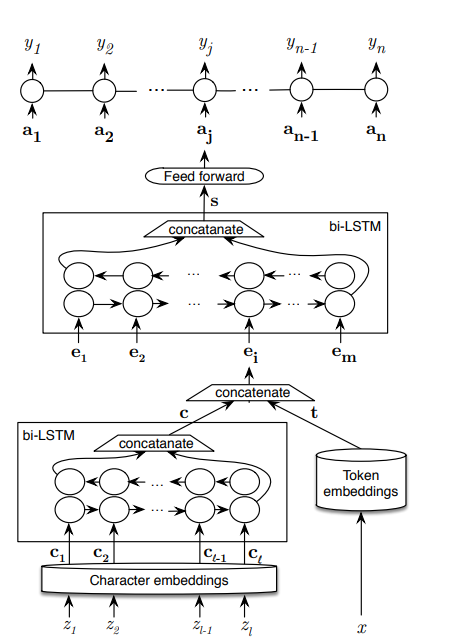

In [106]:
# Model 

from tensorflow.keras import layers


# step 1 : TOKEN EMBEDDING
token_inputs = layers.Input(shape=[],dtype=tf.string,name='token_input')   # scalar x in the above image
token_embeddings = tf_hub_embedding_layer(token_inputs)  # Universal sentence encoder Instead of Glove mentioned in the paper
token_outputs = layers.Dense(units=128,
                             activation="relu",name = "Token_out_dense")(token_embeddings)   # Vector t in the image
token_model=tf.keras.Model(inputs = token_inputs,
                           outputs = token_outputs)

token_model.summary()


Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_input (InputLayer)    [(None,)]                 0         
                                                                 
 Universal_Sentence_Encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 Token_out_dense (Dense)     (None, 128)               65664     
                                                                 
Total params: 256,863,488
Trainable params: 65,664
Non-trainable params: 256,797,824
_________________________________________________________________


> 🎉 In the jouranl it is mentioned that the output of the token embedding size as 300 , we are setting it to 128 

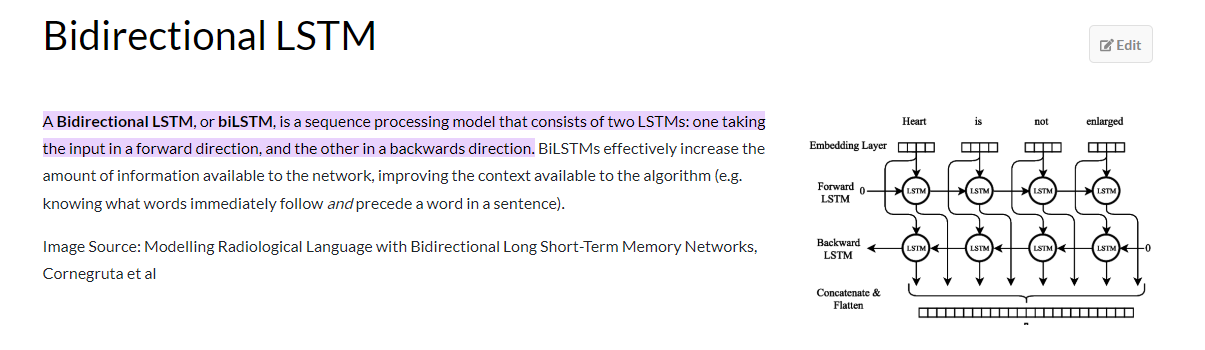

Credits : https://paperswithcode.com/method/bilstm#:~:text=A%20Bidirectional%20LSTM%2C%20or%20biLSTM,other%20in%20a%20backwards%20direction.

In [107]:
#Step 2 : CHARACTER EMBEDDING
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectoriser(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
# The size of the bi-LSTM model 25*2 = 50 which is mentioned in the paper
# If the size is multiple of 8 , tensorflow GPU can do the operation faster , instead of 50 , it may be 48 
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

char_model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 char_input (InputLayer)     [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           7250      
                                                                 
 bidirectional_6 (Bidirectio  (None, 50)               10200     
 nal)                                                            
                                                                 
Total params: 17,450
Trainable params: 17,450
Non-trainable params: 0
_________________________________________________________________


In [108]:
# Step 3 : Concatenate the two embeddings - Hybrid Embeddings 

print(token_model.output.shape , char_model.output.shape)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])
token_char_concat.shape

# Its just like adding more dimensions to the existing vector 
# a = [4 ,7, 8]  3 dimensional vector
# b  = [4, 7, 8, 5] 4 dimensional vector



(None, 128) (None, 50)


TensorShape([None, 178])

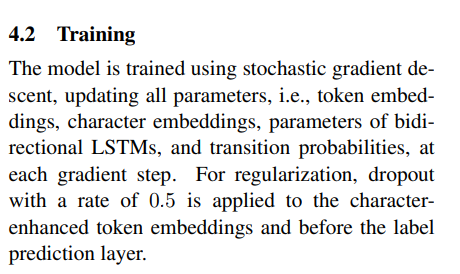

In [109]:
# We are avoiding the second Bi-LSTM model represented in hte paper on top of the concatenated embeddings
# We use simple dense layer model for this 

combined_dropout = layers.Dropout(0.5,name='dropout_after_embeddings')(token_char_concat)
combined_dense = layers.Dense(units=200,
                              activation='relu',name ='dense_before_labelling')(combined_dropout)
final_dropout = layers.Dropout(0.5,name='dropout_before_labelling')(combined_dense)
output_layer = layers.Dense(units = num_classes, activation = "softmax",name ='dense_labelling')(final_dropout)
model_4 = tf.keras.Model(
    inputs = [token_model.input,char_model.input],  
    # inputs = token_char_concat, # Why did we do cancatenation ? # If you do like this model doesnt involve the token embedding , char embedding inside
    outputs = output_layer,
    name ="model_4_hybrid_embedding"
)

In [110]:
model_4.summary()

Model: "model_4_hybrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 Universal_Sentence_Encoder (Ke  (None, 512)         256797824   ['token_in

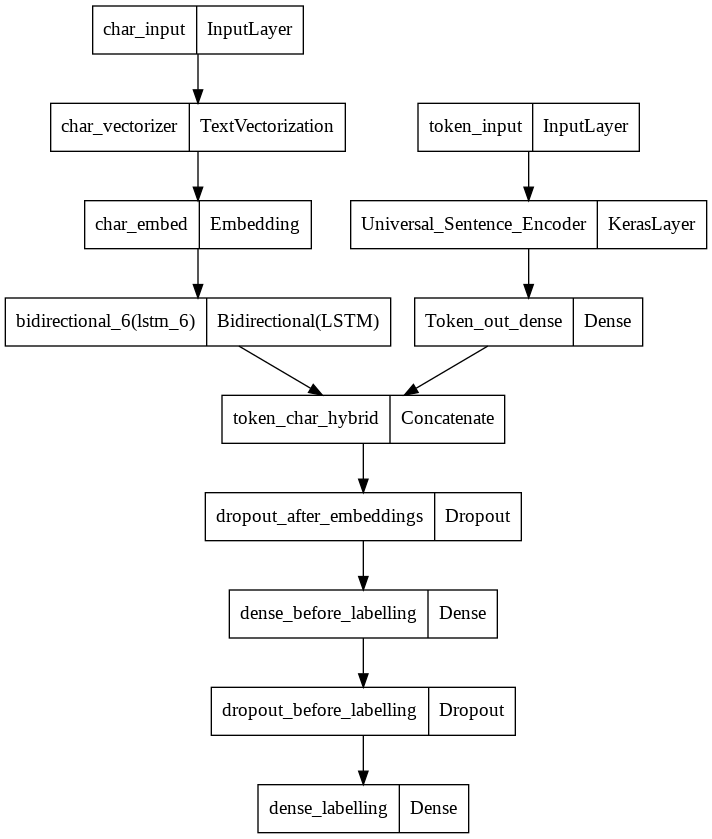

In [112]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)